<h3>Using Foresight and sklearn</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as  s
print s.__version__
import numpy as np
%matplotlib inline
from  matplotlib import pyplot as plt

from sklearn.datasets import make_classification as makec
import sys
sys.path.append('./TreeMethods/')
import Foresight as Fsht
#allow realtime editing of the class 
reload(Fsht)
Foresight = Fsht.Foresight
from sklearn.model_selection import train_test_split

#the key is that we'll build forests using sklearn's trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score


0.19.0


In [81]:
n_classes = 10
n_features = 10 * n_classes
Xd1, yd1 = makec(n_samples=10000, n_features=n_features, n_informative=int(n_features*0.1), n_redundant=3, 
                n_repeated=2, n_classes=n_classes)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xd1, yd1 , train_size=0.1, test_size=0.9, random_state=42)

In [82]:
#fit foresight, to the data, passing in Xtest
fsd1 = Foresight(Xtrain, Ytrain, aux_data=Xtest)
fsd1.fit()

In [83]:
#now select some features. and construct a forest
Nfeats = 5
n_trees = 100
sel_feats = np.zeros((n_trees, Nfeats), dtype=int)
trees = []
for i in range(n_trees):
    sel_feats[i] = fsd1.select_n_features(Nfeats)
    clf = DecisionTreeClassifier(max_features=Nfeats)
    #boot-strap resample from the training data
    bs_rs = np.random.choice(len(Xtrain), size=len(Xtrain), replace=True)
    
    clf.fit(Xtrain[bs_rs,:][: , sel_feats[i]], Ytrain[bs_rs])
    
    #save this tree 
    trees.append(clf)

In [84]:
#get predictions for each class, in a way exactly like the sklearn Random forests
#note we have to keep sel_feats and use those features for each tree
predictions = np.array([DT.predict_proba(Xtest[:, sel_feats[i]]) for i, DT in enumerate(trees)])

In [85]:
#forecast + RF predictions:
predict = np.argmax(np.sum(predictions, axis=0), axis=1)

In [86]:
#now compare with normal random forests, with  max_features=Nfeats
rf = RandomForestClassifier(n_estimators=n_trees, max_features=Nfeats)
rf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
rf_pred = rf.predict(Xtest)
#just a test to show that sklearn RF works like this.
rf_predictions = np.array([DT.predict_proba(Xtest) for DT in rf.estimators_])
rf_pred1 = np.argmax(np.sum(rf_predictions, axis=0), axis=1)

In [89]:
#some metrics
print 'RF  ', f1_score(Ytest, rf_pred, average='micro')
print 'RF  ', f1_score(Ytest, rf_pred1, average='micro')
print 'f_RF', f1_score(Ytest, predict, average='micro')

RF   0.376222222222
RF   0.376222222222
f_RF 0.352222222222


<h3>Now look at feature importances/selection</h3>

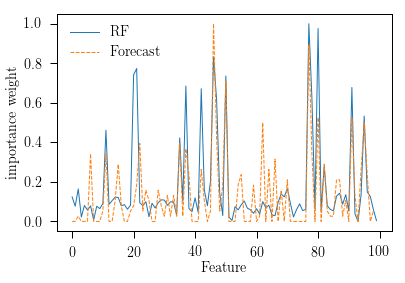

In [91]:
#feature importance for RF
feature_importances_ = rf.feature_importances_ - np.amin(rf.feature_importances_)
feature_importances_ = feature_importances_/np.amax(feature_importances_)
_ = plt.plot(np.arange(n_features), feature_importances_, label='RF')

#feature importances for Forecast
h = np.histogram(sel_feats, bins=np.arange(n_features))[0]
h = h - np.amin(h)
_ = plt.plot(np.arange(len(h)), h*1.0/(np.amax(h)), '--', label='Forecast')
plt.legend()
plt.xlabel('Feature')
plt.ylabel('importance weight')